In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.applications as app
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os
import yaml
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from collections import Counter
import numpy as np
from sklearn.model_selection import train_test_split


with open('../config.yml', 'r') as file:
    config = yaml.safe_load(file)


image_size = config['donnees']['image']['size']
normalize = config['donnees']['image']['normalize']
standardize = config['donnees']['image']['standardize']
grayscale = config['donnees']['image']['grayscale']

def resize_and_rename_images_of_folder(folder,subfolder,size):
       data_path = os.path.join(os.path.abspath(os.path.join(os.getcwd(), "../..")), "archive","data", folder, subfolder)
       resized = os.path.join(os.path.abspath(os.path.join(os.getcwd(), "../..")), "archive","data", folder, f"resized_{subfolder}_{size}")
       os.makedirs(resized, exist_ok=True) # au cas ou 


       for count,filename in enumerate(os.listdir(data_path)):
        image_path = os.path.join(data_path, filename)
        image = Image.open(image_path)
        image_resized = image.resize((size,size))
        output_path = os.path.join(resized, f'{subfolder}_{count}.jpg')
        image_resized.save(output_path)


       

def load_and_preprocess_image(image,grayscale,normalize,standardize):
    # Charger l'image
    img = tf.io.read_file(image)
    img = tf.image.decode_image(img, channels=1 if grayscale else 3)  # Convertir en niveaux de gris si spécifié

    if normalize:
        img = img / 255.0  # Normaliser entre 0 et 1

    if standardize:
        img = (img - tf.reduce_mean(img)) / tf.math.reduce_std(img)  # Standardisation

    return img

def load_images_with_preprocessing(directory, size):

    images = []
    labels = []

    subfolders = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
    class_names = [f"resized_{subfolder}_{size}" for subfolder in subfolders]

    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(directory, class_name)
        
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)

            img = Image.open(img_path).convert('L')  # Convertir en niveaux de gris 
            img_array = np.array(img)  
            
            img_array = np.expand_dims(img_array, axis=-1)

            images.append(img_array)
            labels.append(label)


    return np.array(images, dtype=np.float32), np.array(labels, dtype=np.int32)


In [2]:
directory = os.path.join(os.path.abspath(os.path.join(os.getcwd(), "..")), "data", "Training")

# Vérifier et générer les dossiers redimensionnés
subfolders = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
image_size = 256  # Taille de redimensionnement

for subfolder in subfolders:
    folder_path = os.path.join(directory, f"resized_{subfolder}_{image_size}")
    if not os.path.exists(folder_path):
        print(f"Le dossier {folder_path} est manquant. Génération en cours...")
        resize_and_rename_images_of_folder(folder='Training', subfolder=subfolder, size=image_size)

# Charger les images redimensionnées et prétraitées
X, y = load_images_with_preprocessing(directory, image_size)
print(f"Chargé {len(X)} images avec {len(y)} étiquettes.")


Chargé 2870 images avec 2870 étiquettes.


In [5]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y
)


In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models


model = models.Sequential([
    layers.Input(shape=(256, 256, 1)),

    # Bloc 1
    layers.Conv2D(32, (3, 3), activation='sigmoid'),
    
    # Bloc 2
    layers.Conv2D(64, (3, 3), activation='sigmoid'),
    layers.MaxPooling2D((2, 2)),

    # Bloc 3
    layers.Conv2D(128, (3, 3), activation='sigmoid'),

    # Bloc 4
    layers.Conv2D(128, (3, 3), activation='sigmoid'),
    layers.MaxPooling2D((2, 2)),

    # Couche Fully Connected
    layers.Flatten(),
    layers.Dense(128, activation='relu'), 
    layers.Dense(4, activation='softmax')

])


# Création du modèle
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))

batch_size = 32
train_dataset = (
    train_dataset
    .shuffle(buffer_size=len(X_train))  
    .batch(batch_size)                  
    .prefetch(tf.data.experimental.AUTOTUNE)  # Optimisation de préchargement
)

val_dataset = (
    val_dataset
    .batch(batch_size)                 
    .prefetch(tf.data.experimental.AUTOTUNE)  # Optimisation de préchargement
)

In [8]:
history=model.fit(train_dataset, epochs=10, validation_data= val_dataset)

Epoch 1/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 301s 4s/step - accuracy: 0.2493 - loss: 46.1960 - val_accuracy: 0.2875 - val_loss: 1.3781
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 277s 4s/step - accuracy: 0.2940 - loss: 1.3749 - val_accuracy: 0.2875 - val_loss: 1.3696
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 355s 5s/step - accuracy: 0.2876 - loss: 1.3668 - val_accuracy: 0.2875 - val_loss: 1.3638
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 269s 4s/step - accuracy: 0.2887 - loss: 1.3629 - val_accuracy: 0.2875 - val_loss: 1.3593
Epoch 5/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 353s 5s/step - accuracy: 0.2933 - loss: 1.3587 - val_accuracy: 0.2875 - val_loss: 1.3561
Epoch 6/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 270s 4s/step - accuracy: 0.2930 - loss: 1.3557 - val_accuracy: 0.2875 - val_loss: 1.3538
Epoch 7/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 373s 5s/step - accuracy: 0.2901 - loss: 1.3544 - val_accuracy: 0.2875 - val_loss: 1.3521
Epoch 8/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 298s 4s/step - accuracy: 0.2766 - loss: 1.3513 - val_accuracy: 0.2875 - 

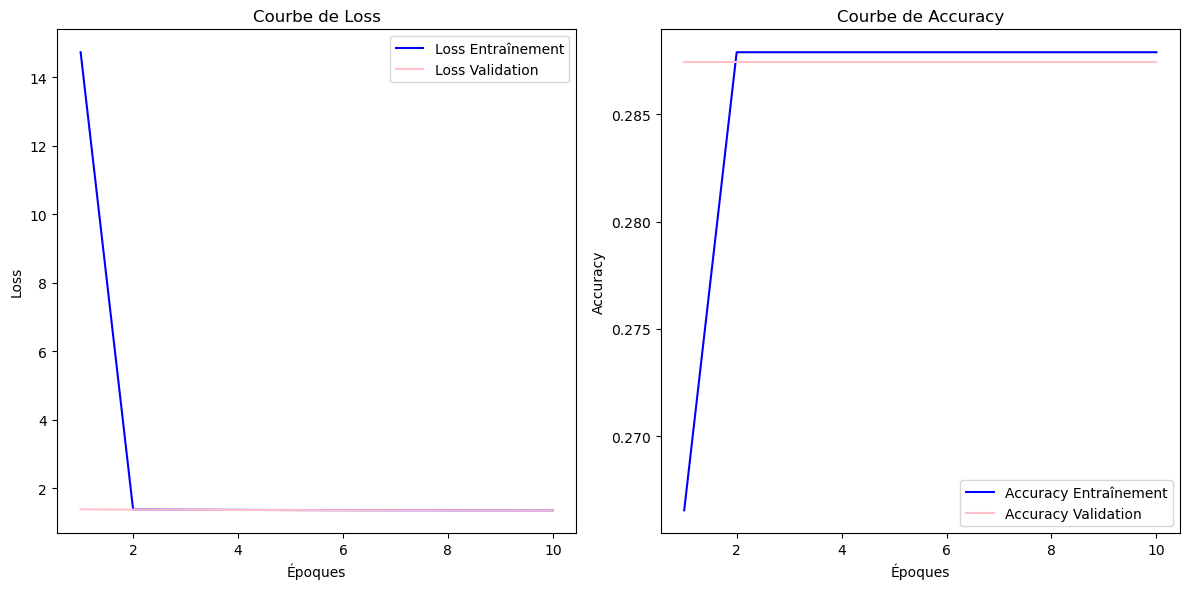

In [9]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.figure(figsize=(12, 6))

# Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Loss Entraînement', color='blue')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Loss Validation', color='pink')
plt.title('Courbe de Loss')
plt.xlabel('Époques')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Accuracy Entraînement', color='blue')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Accuracy Validation', color='pink')
plt.title('Courbe de Accuracy')
plt.xlabel('Époques')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
# Charger les images avec vos fonctions de preprocessing
# Définir le chemin vers Training
directory = os.path.join(os.path.abspath(os.path.join(os.getcwd(), "../..")), "archive","data","Testing")

# Vérifier et générer les dossiers redimensionnés
subfolders = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
image_size = 256  # Taille de redimensionnement

for subfolder in subfolders:
    folder_path = os.path.join(directory, f"resized_{subfolder}_{image_size}")
    if not os.path.exists(folder_path):
        print(f"Le dossier {folder_path} est manquant. Génération en cours...")
        resize_and_rename_images_of_folder(folder='Testing', subfolder=subfolder, size=image_size)

# Charger les images redimensionnées et prétraitées
X_test, y_test = load_images_with_preprocessing(directory, image_size)
print(f"Chargé {len(X_test)} images avec {len(y_test)} étiquettes.")


Chargé 394 images avec 394 étiquettes.


In [11]:
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

batch_size = 32
test_dataset = (
    test_dataset
    .batch(batch_size)                  
    .prefetch(tf.data.experimental.AUTOTUNE)  # Optimisation de préchargement
)

loss, accuracy = model.evaluate(test_dataset)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 526ms/step - accuracy: 0.5340 - loss: 1.3343
Loss: 1.4268300533294678
Accuracy: 0.25380709767341614


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
Classe 'glioma_tumor': 100.00% de prédictions correctes, 0.00% de prédictions incorrectes
Classe 'pituitary_tumor': 0.00% de prédictions correctes, 100.00% de prédictions incorrectes
Classe 'no_tumor': 0.00% de prédictions correctes, 100.00% de prédictions incorrectes
Classe 'meningioma_tumor': 0.00% de prédictions correctes, 100.00% de prédictions incorrectes


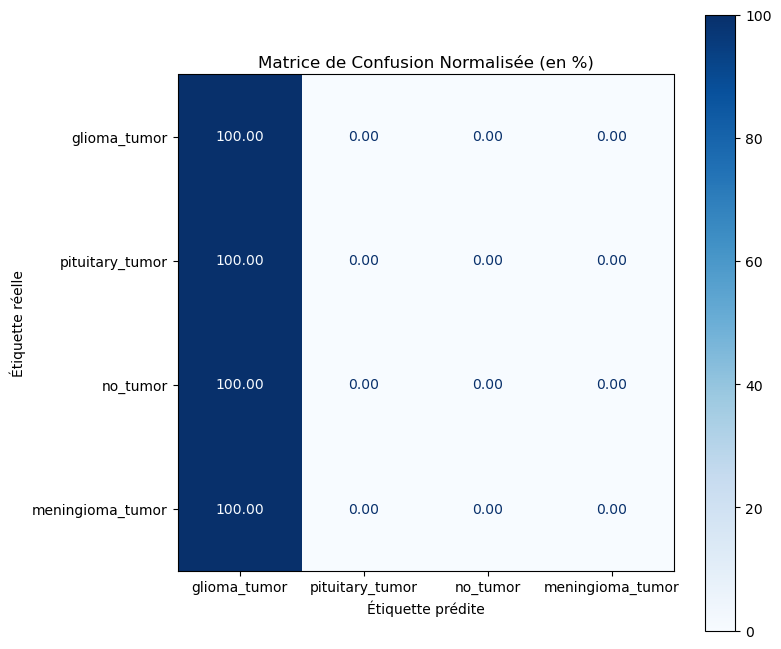

In [12]:
# Étape 1 : Extraire les vraies étiquettes et faire les prédictions
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
true_labels = []
pred_labels = []

for images, labels in test_dataset:
    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)

    true_labels.extend(labels.numpy())
    pred_labels.extend(predicted_classes)

# Étape 2 : Calculer la matrice de confusion
cm = confusion_matrix(true_labels, pred_labels)
class_names = ['glioma_tumor', 'pituitary_tumor', 'no_tumor', 'meningioma_tumor']

# Étape 3 : Normaliser la matrice pour obtenir les pourcentages par classe
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # Pourcentage par ligne

# Étape 4 : Afficher la matrice de confusion avec les pourcentages
fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, ax=ax, values_format=".2f")
plt.title("Matrice de Confusion Normalisée (en %)")
plt.ylabel('Étiquette réelle')
plt.xlabel('Étiquette prédite')

# Étape 5 : Afficher les pourcentages de prédictions correctes et incorrectes par classe
correct_percentages = np.diag(cm_normalized)  # Pourcentage correct par classe (diagonale)
incorrect_percentages = 100 - correct_percentages  # Pourcentage incorrect par classe

for i, class_name in enumerate(class_names):
    print(f"Classe '{class_name}': {correct_percentages[i]:.2f}% de prédictions correctes, {incorrect_percentages[i]:.2f}% de prédictions incorrectes")

plt.show()

In [16]:
historySig_json = {
    "model_name": "Sigmoid_mod",
    "epochs": 0,
    "metrics": {}
}

historySig_json["epochs"] = len(history.history["loss"])
historySig_json["metrics"] = history.history

In [17]:
import json

with open('historySig.json', 'w') as f:
    json.dump(historySig_json, f, indent=4)

In [20]:
model.save(os.path.join(os.path.abspath(os.path.join(os.getcwd(), "..")), "models","sig_model.h5"))